In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import fastai
fastai.__version__

'1.0.50.post1'

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

In [4]:
from pathlib import Path
path = Path('c:/Users/user/git/rick_morty/data')
path.ls()

[WindowsPath('c:/Users/user/git/rick_morty/data/cleaned.csv'),
 WindowsPath('c:/Users/user/git/rick_morty/data/export.pkl'),
 WindowsPath('c:/Users/user/git/rick_morty/data/models'),
 WindowsPath('c:/Users/user/git/rick_morty/data/morty'),
 WindowsPath('c:/Users/user/git/rick_morty/data/rick')]

In [5]:
verify_images(path/'morty')
verify_images(path/'rick')

In [18]:
ImageDataBunch.from_folder??

In [20]:
np.random.seed(2)
data = ImageDataBunch.from_folder(path, valid_pct=0.3, size=224, ds_tfms=get_transforms(), bs=bs, num_workers=0)
data = data.normalize(imagenet_stats)

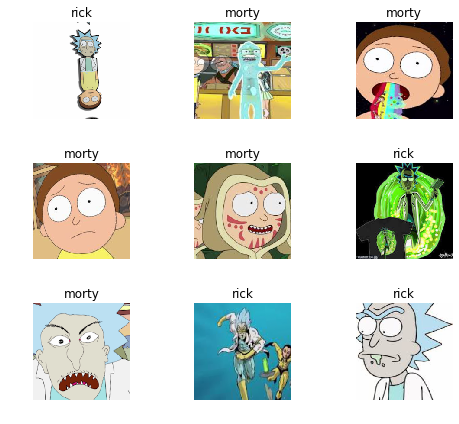

In [10]:
data.show_batch(rows=3, figsize=(7,6))

In [11]:
len(data.classes),data.c, data.classes

(2, 2, ['morty', 'rick'])

## Training: resnet34

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [13]:
learn.load('stage-1');

In [39]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.052712,0.410587,0.214286,00:01
1,0.064846,0.297625,0.142857,00:01
2,0.078184,0.218776,0.071429,00:01
3,0.068361,0.189788,0.035714,00:01


In [16]:
learn.save('stage-1')

In [17]:
learn.export()

## Results

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

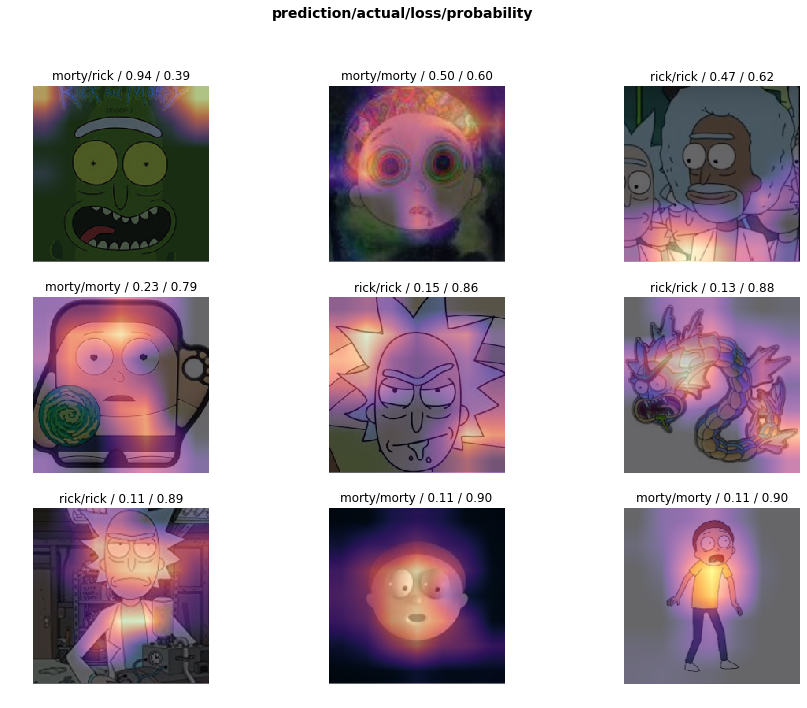

In [12]:
interp.plot_top_losses(9, figsize=(15,11))

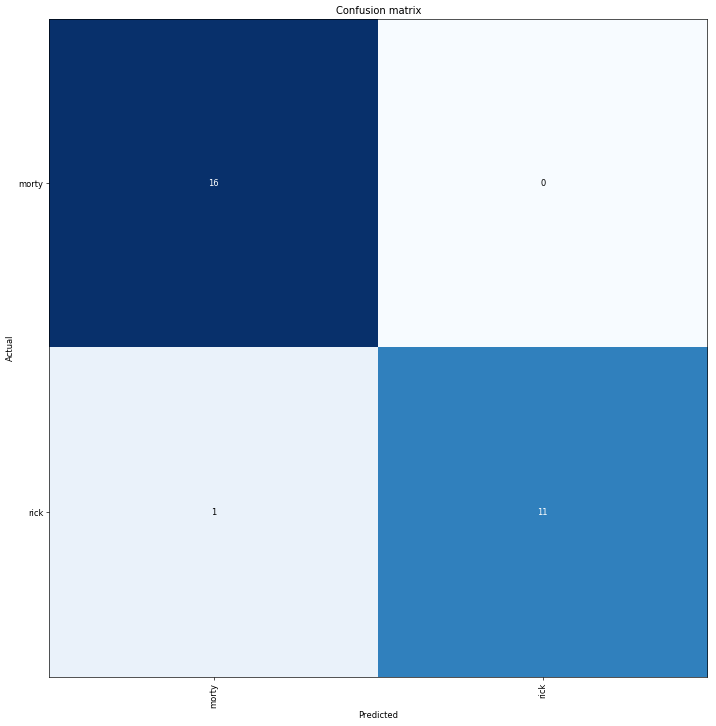

In [13]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [14]:
interp.most_confused(min_val=2)

[]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [36]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.486728,0.290592,0.095399,02:54


In [38]:
learn.load('stage-1');

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


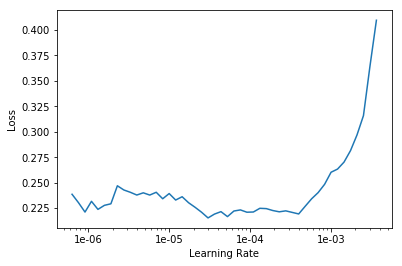

In [40]:
learn.recorder.plot()

In [41]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.212780,0.196887,0.062923,02:53
1,0.206713,0.190975,0.064953,02:47


That's a pretty accurate model!

# CleanUp

In [14]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [29]:
data = ImageDataBunch.from_folder(path, valid_pct=0.1, size=224, ds_tfms=get_transforms(), bs=bs, num_workers=0)
data = data.normalize(imagenet_stats)

In [30]:
learn_cln = cnn_learner(data, models.resnet34, metrics=error_rate)

learn_cln.load('stage-1');

In [31]:
from fastai.widgets import *

In [32]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [33]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

# Production

In [16]:
learn = load_learner(path)

In [17]:
test_path = Path('c:/temp/test')

In [25]:
doc(verify_images)

In [35]:
verify_images(test_path, delete=False)

In [ ]:
plt.figure(figsize=(16, 10))
for i, f in enumerate(test_path.iterdir()):
    img = open_image(f)
    print(img.shape)
    pred_class,pred_idx,outputs = learn.predict(img)
    ax = plt.subplot(3, 3, i+1)
    show_image(img, ax=ax)
    plt.title(str(f.stem) + " is " + str(pred_class))
